# Проект e-learning

In [1]:
import pandas as pd
import requests
import numpy as np
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
url='https://cloud-api.yandex.net/v1/disk/public/resources/download?'

pass_courses='https://disk.yandex.ru/d/jmJxR8yhwCXlaw'
pass_assessments='https://disk.yandex.ru/d/iSVP1sZ7AdW7TQ'
pass_studentAssessment='https://disk.yandex.ru/d/DYd4M5b_8RETsA'
pass_studentRegistration='https://disk.yandex.ru/d/lqHnH8NOZ458iw'



# courses -  список предметов по семестрам
query = requests.get(url+urlencode(dict(public_key=pass_courses)))
courses=pd.read_csv(query.json()['href'])

# assessments - информация об оценках в тесте
query = requests.get(url+urlencode(dict(public_key=pass_assessments)))
assessments=pd.read_csv(query.json()['href'])

# stAss - результаты тестов студентов
query = requests.get(url+urlencode(dict(public_key=pass_studentAssessment)))
stAss=pd.read_csv(query.json()['href']) 

# stReg - информация о регистрации студентов на курсы
query = requests.get(url+urlencode(dict(public_key=pass_studentRegistration)))
stReg=pd.read_csv(query.json()['href']) 



### Предварительный анализ данных

Курс - это уникальное сочетание идентификационного кода предмета (code_module) и идентификационного кода семестра (code_presentation).  Курс включает тесты ТМА, иногда -  СМА, и заканчивается экзаменом (Exam), при этом сумма weight всех тестов(ТМА и СМА) должна быть равна 100. Например: AAA	2013J - это один курс, а AAA 2014J - это другой курс. 


У курсов CCC 2014B и CCC 2014J по два экзамена в таблице assessments, но после объединения таблиц - в сводной таблице sv, экзаменов с кодами 40087 и 40088 нет и данные курсы тоже подходят под вышенаписанное определение.

In [3]:
assessments[:12]

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0
5,AAA,2013J,1757,Exam,NaN,100.0
6,AAA,2014J,1758,TMA,19.0,10.0
7,AAA,2014J,1759,TMA,54.0,20.0
8,AAA,2014J,1760,TMA,117.0,20.0
9,AAA,2014J,1761,TMA,166.0,20.0


In [4]:
assessments.isna().sum() 

code_module           0
code_presentation     0
id_assessment         0
assessment_type       0
date                 11
weight                0
dtype: int64

In [5]:
# пустые значения есть только в колонке date - окончательная  дата сдачи теста, 
# выясним у каких конкретно типов теста (оценка преподавателя (TMA), компьютерная (СМА), экзамен по курсу (Exam))

assessments.query("date == 'NaN'").assessment_type 

5      Exam
11     Exam
23     Exam
35     Exam
47     Exam
53     Exam
62     Exam
63     Exam
72     Exam
73     Exam
108    Exam
Name: assessment_type, dtype: object

In [6]:
# для выполнения заданий данного проекта экзамены критичны, поэтому удалять строки с пустыми значениями не будем,
# а заполним пустые значения колонки date, для этого объединим таблицы courses и assessments. 

courses_assessments=assessments.merge(courses, on = ['code_module','code_presentation'])
courses_assessments.query("assessment_type == 'Exam' & date != 'NaN'")

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
87,DDD,2013B,25340,Exam,240.0,100.0,240
94,DDD,2013J,25354,Exam,261.0,100.0,261
101,DDD,2014B,25361,Exam,241.0,100.0,241
113,EEE,2013J,30713,Exam,235.0,100.0,268
118,EEE,2014B,30718,Exam,228.0,100.0,241
123,EEE,2014J,30723,Exam,235.0,100.0,269
136,FFF,2013B,34872,Exam,222.0,100.0,240
149,FFF,2013J,34885,Exam,236.0,100.0,268
162,FFF,2014B,34898,Exam,227.0,100.0,241
175,FFF,2014J,34911,Exam,241.0,100.0,269


In [70]:
# Проведя анализ мы видим что date <= module_presentation_length для строк с assessment_type == 'Exam'
# принимаем решение заполнить пустые date из  колонки module_presentation_length

courses_assessments['date']=courses_assessments\
                           .apply(lambda x:  x['date']  if x['date'] > 0  else x['module_presentation_length'] ,axis=1)

In [71]:
# объединяем courses_assessments с оставшимися таблицами и получаем общую таблицу sv

sv=courses_assessments.merge(stAss, on = 'id_assessment')
sv=sv.merge(stReg, on = ['code_module','code_presentation','id_student'])\
                        .sort_values(['code_module','code_presentation','id_student'])

sv.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
0,AAA,2013J,1752,TMA,19.0,10.0,268,11391,18,0,78.0,-159.0,NaN
1,AAA,2013J,1753,TMA,54.0,20.0,268,11391,53,0,85.0,-159.0,NaN
2,AAA,2013J,1754,TMA,117.0,20.0,268,11391,115,0,80.0,-159.0,NaN
3,AAA,2013J,1755,TMA,166.0,20.0,268,11391,164,0,85.0,-159.0,NaN
4,AAA,2013J,1756,TMA,215.0,30.0,268,11391,212,0,82.0,-159.0,NaN


In [72]:
# отсортируем по типу теста Exam и посмотрим распределение студентов по курсам
# в предоставленных данных экзаменами заканчиваются только шесть курсов. 

sv.query("assessment_type == 'Exam'")\
  .groupby(['code_module','code_presentation','id_assessment'])\
  .agg({'id_student':'count'})

id_student
code_module code_presentation id_assessment            
CCC         2014B             24290                 747
            2014J             24299                1168
DDD         2013B             25340                 602
            2013J             25354                 968
            2014B             25361                 524
            2014J             25368                 950

In [73]:
# Проанализировав задания, делаем вывод, что нам нужны только данные по экзаменам.
#(подробные рассуждения приведены в конце работы)

exam = sv.loc[sv.assessment_type == 'Exam'].copy()

In [74]:
exam

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
47117,CCC,2014B,24290,Exam,241.0,100.0,241,29764,230,0,94.0,-34.0,NaN
47126,CCC,2014B,24290,Exam,241.0,100.0,241,29820,230,0,76.0,-57.0,NaN
47133,CCC,2014B,24290,Exam,241.0,100.0,241,40604,234,0,66.0,-17.0,NaN
47142,CCC,2014B,24290,Exam,241.0,100.0,241,42638,230,0,50.0,-52.0,NaN
47154,CCC,2014B,24290,Exam,241.0,100.0,241,46605,230,0,98.0,-54.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90904,DDD,2014J,25368,Exam,262.0,100.0,262,2677210,243,0,71.0,-109.0,NaN
90911,DDD,2014J,25368,Exam,262.0,100.0,262,2678380,242,0,64.0,-127.0,NaN
90924,DDD,2014J,25368,Exam,262.0,100.0,262,2684043,243,0,69.0,-42.0,NaN
90931,DDD,2014J,25368,Exam,262.0,100.0,262,2685863,243,0,49.0,-136.0,NaN


In [75]:
exam.shape

(4959, 13)

In [76]:
exam.isna().sum()
# пустые значения только у даты отмены регистрации, что соответствует окончанию курса

code_module                      0
code_presentation                0
id_assessment                    0
assessment_type                  0
date                             0
weight                           0
module_presentation_length       0
id_student                       0
date_submitted                   0
is_banked                        0
score                            0
date_registration                0
date_unregistration           4958
dtype: int64

In [77]:
exam[['is_banked','score','date_registration','date_submitted']].describe()
# оценок отрицательных и больше 100 баллов - нет, но есть оценки равные 0 баллов
# пересдач - нет
# дата регистрации - в среднем за 72 дня до начала курса, меньше 25%  зарегистрировались после начала курса
# дата сдачи теста - стандартное отклонение около 6 дней

,is_banked,score,date_registration,date_submitted
count,4959.0,4959.000000,4959.000000,4959.000000
mean,0.0,65.572898,-72.248639,238.483565
std,0.0,20.579186,51.168107,5.717577
min,0.0,0.000000,-310.000000,229.000000
25%,0.0,51.000000,-102.000000,234.000000
50%,0.0,67.000000,-58.000000,241.000000
75%,0.0,82.000000,-30.000000,243.000000
max,0.0,100.000000,101.000000,285.000000


In [78]:
exam.dtypes

code_module                    object
code_presentation              object
id_assessment                   int64
assessment_type                object
date                          float64
weight                        float64
module_presentation_length      int64
id_student                      int64
date_submitted                  int64
is_banked                       int64
score                         float64
date_registration             float64
date_unregistration           float64
dtype: object

In [79]:
exam.query("date_unregistration !='NaN' ")
# у одного экзамена стоит дата отмены регистрации, при этом экзамен сдан, будем считать это технической ошибкой

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
81535,DDD,2013J,25354,Exam,261.0,100.0,261,425543,237,0,33.0,-39.0,232.0


In [80]:
exam.query("module_presentation_length < date_submitted")
# несколько сдавших экзамен после окончания семестра, удалять эти строки не будем, они потребуются в шестом задании

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration
47474,CCC,2014B,24290,Exam,241.0,100.0,241,169380,242,0,78.0,-34.0,NaN
49948,CCC,2014B,24290,Exam,241.0,100.0,241,555008,266,0,56.0,-46.0,NaN
50528,CCC,2014B,24290,Exam,241.0,100.0,241,577245,243,0,34.0,-25.0,NaN
60001,CCC,2014J,24299,Exam,269.0,100.0,269,555498,285,0,58.0,-129.0,NaN
66932,DDD,2013B,25340,Exam,240.0,100.0,240,81351,248,0,0.0,-12.0,NaN
71964,DDD,2013B,25340,Exam,240.0,100.0,240,532491,241,0,49.0,-120.0,NaN
72390,DDD,2013B,25340,Exam,240.0,100.0,240,538611,241,0,51.0,-82.0,NaN
73363,DDD,2013B,25340,Exam,240.0,100.0,240,548535,241,0,60.0,-24.0,NaN
84013,DDD,2014B,25361,Exam,241.0,100.0,241,391924,251,0,69.0,-93.0,NaN
86965,DDD,2014B,25361,Exam,241.0,100.0,241,631388,242,0,78.0,-15.0,NaN


In [81]:
exam.query("date_registration>=date_submitted")
# проверяем нет ли ошибок в датах

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length,id_student,date_submitted,is_banked,score,date_registration,date_unregistration


## Выполнение заданий

#### 1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).

Сначала посмотрим, есть ли студенты сдававшие один и тот же курс больше одного раза, для этого сгруппируем наши данные по курсу (исходя из нашего определения курса -по code_module и code_presentation) и индентификационному номеру студента. 

In [82]:
exam.groupby(['code_module','code_presentation','id_student'])\
    .agg({'assessment_type':'count'})\
    .sort_values('assessment_type')

assessment_type
code_module code_presentation id_student                 
CCC         2014B             29764                     1
DDD         2013J             604317                    1
                              604281                    1
                              604156                    1
                              604072                    1
...                                                   ...
CCC         2014J             679886                    1
                              679750                    1
                              679733                    1
                              680133                    1
DDD         2014J             2689863                   1

[4959 rows x 1 columns]

Таких студентов нет, поэтому сгруппировав данные по индентификационному номеру студента можно подсчитать количество успешно сданных экзаменов у каждого студента и отобрать строки где успешно сдан только один.

In [83]:
# оценка ниже 40 по условию - это неуспешная сдача экзамена, сделаем колонку успешных сдач 
# колонка success  будет содержать 1, если экзамен успешен и 0 - если нет

exam['success']=exam['score'].apply(lambda x:  1 if x >= 40  else 0)

In [84]:
exam_success=exam.groupby(['id_student']).agg({"success":'sum'})
success=len(exam_success.loc[exam_success['success']==1])

In [85]:
success

3802

Ответ: 3802 студента успешно сдали только один курс

#### 2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [86]:
# исходя из нашего определения курса, группируем по code_module и code_presentation
# колонка success  содержит 1, если экзамен успешен и 0 - если нет, поэтому суммируя колонку success получаем
# количество успешных экзаменов, а также подсчитываем все попытки сдачи экзаменов

exam_end=exam.groupby(['code_module','code_presentation','id_assessment']).agg({'success':'sum','assessment_type':'count'})

# переименовываем колонку,содержащую все попытки сдачи экзаменов
exam_end=exam_end.rename(columns={'assessment_type':'total'})

# делаем новую колонку end, которая будет содержать завершаемость
exam_end['end']=exam_end.success/exam_end.total 

In [87]:
exam_end

success  total       end
code_module code_presentation id_assessment                          
CCC         2014B             24290              664    747  0.888889
            2014J             24299             1019   1168  0.872432
DDD         2013B             25340              504    602  0.837209
            2013J             25354              878    968  0.907025
            2014B             25361              485    524  0.925573
            2014J             25368              842    950  0.886316

In [88]:
exam_end.end.idxmax()

('DDD', '2014B', 25361)

In [89]:
exam_end.end.idxmin()

('DDD', '2013B', 25340)

Ответ: самый сложный экзамен - 25340, курс с самой низкой завершаемостью - DDD 2013B\
       самый легкий экзамен - 25361, курс с самой высокой завершаемостью - DDD 2014B 

*Если посчитать разницу в процентах между самым сложным и самым легким получится 9%, мне кажется разница достаточно маленькая и экзамены примерно одинаковы по сложности.


#### 3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом)

In [90]:
#определим средний срок по предмету - code_module и индентификационному коду экзамена - id_assessment
#округлим получившееся среднее до целого для лучшей визулизации

df=round(exam.query('success==1')\
         .groupby(['code_module','code_presentation','id_assessment'], as_index = False)\
         .agg({'date_submitted':'mean'}))

In [91]:
# переименовываем колонку,содержащую средний срок сдачи экзамена

df=df.rename(columns={'date_submitted':'date_submitted_average'})

Ответ представлен в таблице ниже и на графике

In [92]:
df[['code_module','id_assessment','date_submitted_average']]

,code_module,id_assessment,date_submitted_average
0,CCC,24290,232.0
1,CCC,24299,244.0
2,DDD,25340,230.0
3,DDD,25354,240.0
4,DDD,25361,235.0
5,DDD,25368,243.0


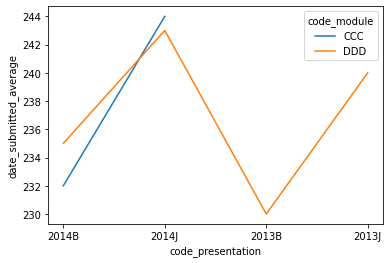

In [93]:
# для лучшей визулизации возьмем пару code_module code_presentation, что аналогично паре code_module id_assessment

sns.lineplot(x='code_presentation', y='date_submitted_average', data=df, hue='code_module')

#### 4. Выяви самые популярные предметы (ТОП-3) по количеству регистраций на них. А также предметы с самым большим оттоком (ТОП-3)

В данном задании надо определить популярность (отток) предмета среди студентов, независимо от того были ли получены оценки за этот предмет, поэтому возьмем таблицу  stReg с первоначальными данными о регистрации/отмене регистрации студентов на курсы.

Популярность предмета - это сколько уникальных студентов записалось на этот предмет, если студент записался на один и тот же предмет несколько раз, то популярнее в среде студентов этот предмет не становится. Аналогично по оттоку.


Чтобы выполнить это задание, нам надо группировать данные по предмету - code_module, а не по курсу (code_module и code_presentation) и считать количество регистраций (для популярных) или количество отмен регистраций (для оттока) уникальных студентов.

In [94]:
stReg.isna().sum()

code_module                0
code_presentation          0
id_student                 0
date_registration         45
date_unregistration    22521
dtype: int64

In [95]:
# чтобы получить корректный результат по количеству регистраций удалим строки с пустыми датами регистрации

stReg_reg=stReg.query("date_registration !='NaN'")

In [96]:
stReg_reg=stReg_reg.groupby(['code_module'], as_index = False)\
                   .id_student.nunique()\
                   .sort_values('id_student',ascending=False )

Text(0, 0.5, 'count')

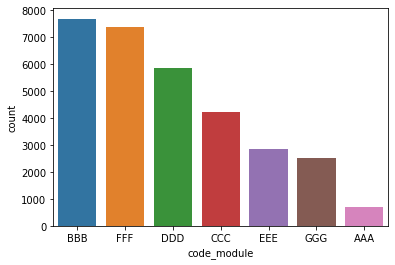

In [97]:
sns.barplot(x='code_module', y='id_student', data=stReg_reg)
plt.ylabel("count")



In [98]:
# чтобы посчитать отток нужны строки с непустыми датами отмены регистрации

stReg_unreg=stReg.query("date_unregistration !='NaN'")

In [99]:
stReg_unreg=stReg_unreg.groupby(['code_module'], as_index = False)\
                       .id_student.nunique()\
                       .sort_values('id_student',ascending=False )

Text(0, 0.5, 'count')

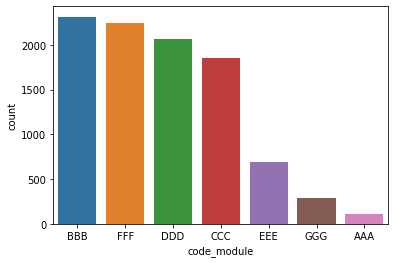

In [100]:
sns.barplot(x='code_module', y='id_student', data=stReg_unreg)
plt.ylabel("count")

Ответ:ТОП-3 популярных предметов BBB, FFF, DDD. ТОП-3 по оттоку - BBB, FFF, DDD

#### 5. Используя pandas, в период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов

завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен

In [101]:
# группируем по семестру -  code_presentation и по коду экзамена
# колонка success  содержит 1, если экзамен успешен и 0 - если нет, поэтому суммируя колонку success получаем
# количество успешных экзаменов, а также подсчитываем все попытки сдачи экзаменов

exam_sem=exam.groupby(['code_presentation','id_assessment'])\
             .agg({"success":'sum','assessment_type':'count','date_submitted':'mean'})

# переименовываем колонку,содержащую все попытки сдачи экзаменов
exam_sem=exam_sem.rename(columns={'assessment_type':'total'})

# делаем новую колонку end, которая будет содержать завершаемость
exam_sem['end']=exam_sem.success/exam_sem.total

In [102]:
exam_sem

success  total  date_submitted       end
code_presentation id_assessment                                          
2013B             25340              504    602      230.179402  0.837209
2013J             25354              878    968      239.505165  0.907025
2014B             24290              664    747      231.617135  0.888889
                  25361              485    524      234.944656  0.925573
2014J             24299             1019   1168      244.392123  0.872432
                  25368              842    950      242.791579  0.886316

In [103]:
exam_sem.end.idxmin()

('2013B', 25340)

In [104]:
exam_sem.date_submitted.idxmax()

('2014J', 24299)

Ответ: семестр с самой низкой завершаемостью курсов 2013B. Семестр с самыми долгими средними сроками сдачи 2014J

#### 6.Построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. 

Метод RFM, в основном, успешно используется маркетологами и анализирует поведение клиентов по трем параметрам:\
R - насколько недавней является последняя покупка клиента,\
F - как часто клиент совершает покупку,\
M - сколько денег тратит клиент.\
Чтобы получить оценку RFM клиента, нужно сначала вычислить оценки R, F и M по шкале от 1 (худший результат) до 5 (лучший результат).

Адаптируем это метод для качественной оценки студентов.

Выберем следующие метрики:\
R - относительное среднее время сдачи одного экзамена,\
F - завершаемость курсов,\
M - среднее количество баллов, получаемое за экзамен.

Каждый сегмент должен иметь понятные характеристики описывающие студентов.

Среднее время сдачи одного экзамена, используемое в наших данных, измеряется как количество дней с начала семестра. Разбить эти данные на группы возможно, но непонятен их смысл для описания характеристики студентов: "студенты сдавшие экзамены в диапазоне с 234 по 240 день" - это плохо или хорошо, как дальше работать с этой информацией?\
Поэтому найдем средний срок сдачи каждого курса и уже относительно него будем считать среднее время сдачи данного курса у студентов - относительный средний срок сдачи курса - метрика R.


In [105]:
# найдем средний срок сдачи для каждого курса 
avg=exam.groupby(['code_module','code_presentation']).agg({'date_submitted':'mean'})

#переименнуем колонку, чтобы при объединении таблиц  названия колонок были понятнее
avg=avg.rename(columns={'date_submitted':'date_avg'})

# объединим таблицы 
exam_st=exam.merge(avg, on=['code_module','code_presentation'])

# теперь можем найти модуль разницы между средним сроком сдачи курса и фактической сдачей курса,
# т.е. относительное время сдачи экзамена
exam_st['data_ras']=exam_st.apply(lambda x: abs(x['date_avg']-x['date_submitted']),axis=1)

In [106]:
# группируем по индификационному коду студента и считаем:
# - среднее отклонение сдачи экзаменов каждого студента от среднего срока сдачи курса,
# - среднее количество баллов,
# - количество успешных экзаменов,
# - общее количество попыток сдачи экзаменов

exam_st=exam_st.groupby('id_student', as_index = False)\
               .agg({'data_ras':'mean' ,'score':'mean',"success":'sum', 'is_banked':'count'})\


# переименовываем колонку,содержащую все попытки сдачи экзаменов
exam_st=exam_st.rename(columns={'is_banked':'total'})

# переименовываем колонки
exam_st=exam_st.rename(columns={'data_ras':'data_ras_avg'})
exam_st=exam_st.rename(columns={'score':'score_avg'})

# делаем новую колонку end, которая будет содержать завершаемость
exam_st['end']=(exam_st.success/exam_st.total)

Определяем интервалы метрик.

In [107]:
# посмотрим на даты сдачи каждого курса -  в основном сдача идет подряд  два-три дня

exam.groupby(['code_module','code_presentation','date_submitted']).agg({'id_student':'count'})

id_student
code_module code_presentation date_submitted            
CCC         2014B             230                    481
                              234                    222
                              236                     30
                              237                      9
                              238                      2
                              242                      1
                              243                      1
                              266                      1
            2014J             243                    170
                              244                    721
                              245                    203
                              248                     46
                              249                      1
                              250                     13
                              251                      5
                              252                      5
                              256                      1
                              259                      2
                              285                      1
DDD         2013B             229                    179
                              230                    240
                              231                    152
                              233                     25
                              234                      1
                              235                      1
                              241                      3
                              248                      1
            2013J             236                      1
                              237                    449
                              241                    227
                              242                    264
                              243                     17
                              244                      2
                              245                      5
                              248                      1
                              250                      1
                              255                      1
            2014B             234                    299
                              236                    209
                              237                      8
                              238                      5
                              242                      2
                              251                      1
            2014J             242                    383
                              243                    488
                              244                     54
                              245                     14
                              248                      2
                              249                      5
                              250                      2
                              256                      1
                              279                      1

Проанализировав сроки сдачи экзаменов студентами мы видим, что основная сдача экзамена идет в течении двух - трех дней, поэтому задаем интервалы метрики R:\
3 - те, кто сдал +- 3 дня от средней, т.е. основная сдача,\
2 - те, кто сдал в ближайшие дни, +- 7 от средней,\
1 - те, кто сдал сильно позже всех, от 7 дней и более.

In [108]:
# посмотрим какие значения принимает колонка - завершаемость курсов
exam_st['end'].value_counts()

1.0    4069
0.0     536
0.5      28
Name: end, dtype: int64

Завершаемость курсов в анализируемых данных принимает только три значения - 0, 0.5 и 1, поэтому для метрики F будем использовать соответствующие им значения 1, 2 и 3:\
1 - не завершен ни один курс\
2 - завершена половина курсов\
3 - завершены все курсы

In [109]:
# определяем крайние значения для метрики М -среднее количество баллов за экзамен
# минимальное
exam_st['score_avg'].min()

0.0

In [110]:
# максимальное
exam_st['score_avg'].max()

100.0

Для метрики М установим следующие значения:\
1 - до 40 баллов - это студенты, получившие неудовлетворительные оценки на экзамене,\
2 - с 40 до 80 баллов - студенты со средней успеваемостью,\
3 - выше 80 - отличники.\
Если мы поделим средние оценки на  интервалы по частоте встречаемости, то интерпретировать результаты будет затруднительно.

In [111]:
# присваиваем метрикам ранги от 1 до 3, от худшего к лучшему
# R: 1 - от 7 дней и более, 2 - +- 7 от средней, 3 - +- 3 дня от средней
# F: 1 - не завершен ни один курс, 2 - завершена половина курсов, 3 - завершены все курсы
# М: 1 - до 40 баллов, 2 - с 40 до 80 баллов,3 - выше 80

exam_st['R'] = exam_st['data_ras_avg'].apply(lambda x: 1 if x>7 else  3 if x<=3 else 2)
exam_st['F'] = exam_st['end'].apply(lambda x: 2 if x==0.5 else  3 if x==1 else 1)
exam_st['M'] = exam_st['score_avg'].apply(lambda x: 1 if x<40 else  3 if x>=80 else   2)

Проведем небольшой анализ получившихся метрик

In [112]:
exam_st.R.value_counts(normalize=True).mul(100)
# примено 97% студентов сдают экзамены в основном потоке

3    96.632851
2     2.805957
1     0.561191
Name: R, dtype: float64

In [113]:
exam_st.M.value_counts(normalize=True).mul(100) 
# примено 12% студентов сдают экзамены неудовлетворительно

2    59.939564
3    28.340168
1    11.720268
Name: M, dtype: float64

Построим графики

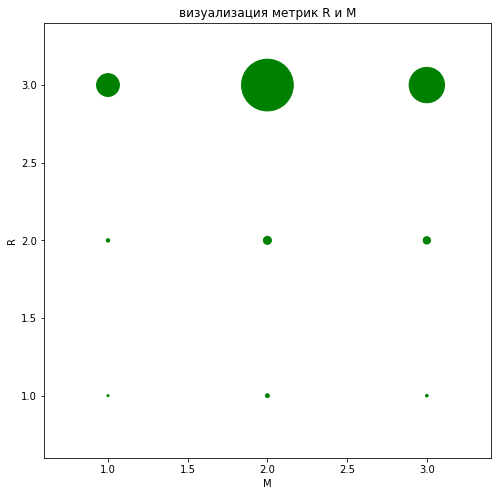

In [114]:
rfm = exam_st.groupby(['R','F','M'], as_index = False).id_student.count()

plt.figure(figsize=(8,8))
plt.scatter(rfm.M, rfm.R, s=rfm.id_student, c='g')
plt.ylim(0.6,3.4)
plt.xlim(0.6,3.4)

plt.title("визуализация метрик R и M")
plt.xlabel("M")
plt.ylabel("R")
plt.show()

Больше всего студентов учатся на средние баллы и сдают экзамены в основном потоке, отличников больше, чем тех, кто учится на неудовлетворительные оценки. Сдающих экзамены невовремя, независимо от оценки, очень мало.

In [115]:
fig = px.scatter(rfm , x="M", y="R", color="id_student", size="id_student", facet_col="F", title='визуализация метрик R, F и M')
fig.update_xaxes(dtick=1) #делаем шаг оси равный 1
fig.update_yaxes(dtick=1) #делаем шаг оси равный 1
fig.show()

На этом графике видна взаимосвязь уже трех метрик, но маленькие значения тут совсем не визуализируются.

In [116]:
# сгруппируем всех студентов по RFM кластерам
exam_st['RFM'] = exam_st['R'].map(str) + exam_st['F'].map(str) + exam_st['M'].map(str)
rfm=exam_st.groupby('RFM', as_index = False).agg({'id_student':'count'})
rfm=rfm.rename(columns={'id_student':'count_'})


#посчитаем проценты для каждой метрики
sum_st=rfm.count_.sum()
rfm['%']=round(rfm['count_']/sum_st*100,2)

In [117]:
rfm

,RFM,count_,%
0,111,4,0.09
1,132,15,0.32
2,133,7,0.15
3,211,12,0.26
4,232,64,1.38
5,233,54,1.17
6,311,520,11.22
7,321,7,0.15
8,322,21,0.45
9,332,2677,57.78


Опишем полученные сегменты:
- 111  (4 чел.) - студенты с неудовлетворительной упеваемостью, не завершившие ни одного курса и сдававшие экзамены сильно позже всех остальных - кандидаты на отчисление

- 132  (15 чел.) - студенты со средней успеваемостью, завершившие все курсы, но сдавшие экзмены сильно позже остальных - надо разбирать каждый случай индивидуально

- 133  (7 чел.) - студенты с отличной успеваемостью, завершившие все курсы, но сдавшие экзмены сильно позже остальных - надо также  разбирать каждый случай индивидуально

- 211  (12 чел.) -студенты не сдавшие экзамены, при этом сдававшие их в течении 7 дней от основной сдачи - кандидаты на пересдачу.

- 232  (64 чел.) - студенты со средней успеваемостью, завершившие все курсы, при этом сдававшие их в течении 7 дней от основной сдачи.

- 233  (54 чел.) - студенты с отличной успеваемостью, завершившие все курсы, при этом сдававшие их в течении 7 дней от основной сдачи.

- 311  (520 чел.) - студенты не сдавшие экзамены, при этом сдававшие их в общем потоке  - кандидаты на пересдачу

- 321  (7 чел.) - студенты не сдавшие экзамены, завершившие только половину курсов и сдававшие экзамены в дни основной сдачи  - кандидаты на пересдачу

- 322  (21 чел.) - студенты со средней успеваемостью, завершившие только половину курсов и сдававшие экзамены в общем потоке

- 332  (2677 чел.) - студенты со средней успеваемостью, завершившие все курсы в дни основной сдачи экзаменов 

- 333  (1252 чел.) - студенты с отличной успеваемостью, завершившие все курсы в дни основной сдачи экзаменов


Основная масса студентов - 87%, вовремя или в течении недели от основной сдачи, сдала экзамены на положительные оценки (333, 332, 232,233). 
Около 12% учащихся не смогли на положительные оценки сдать экзамены (321, 311, 211, 111). 
Очень малая часть студентов сдала экзамены  сильно позже остальных, но получила положительные оценки (132,133).


Вывод: оценив кластеры, можно понять как строить дальнейшую работу со студентами: кого из студентов надо больше мотивировать по учебе, кому надо подтянуть дисциплину (не получается в сроки сдавать экзамены), а кого уже можно и отчислять.

#### гипотезы

При анализе исходных данных у меня возникли некоторые гипотезы, которыми я не воспользовалась при решении задания.\
Хотела бы услышать мнение проверяющего по моим предположениям.


1. Из-за большого количества данных по тестам ТМА и СМА появилась гипотеза, что к экзамену по курсу должны допустить студентов, у которых совокупная оценка за тесты данного курса не менее 40 баллов (тесты при этом, могут быть не все сданы).
2. Из-за большого количества данных по тестам ТМА и СМА появилась гипотеза, что к экзамену по курсу должны допустить студентов, которые сдавали ВСЕ тесты данного курса (оценка не важна).


In [118]:
# объединим все четыре таблицы
courses_assessments_=assessments.merge(courses, on = ['code_module','code_presentation'])
sv_=courses_assessments_.merge(stAss, on = 'id_assessment')
sv_=sv_.merge(stReg, on = ['code_module','code_presentation','id_student'])\
       .sort_values(['code_module','code_presentation','id_student'])

#в колонку test поместим только оценки по тестам ТМА и СМА пересчитанные относительно веса каждого теста
sv_['test']=sv_.apply(lambda x: 0 if x['assessment_type']=='Exam'   else x['weight']*x['score']/100,axis=1)

#в колонку Ex  перенесем оценку за экзамен
sv_['Ex']=sv_.apply(lambda x: x['score'] if x['assessment_type']=='Exam'  else 0,axis=1)


In [119]:
# группируем по курсу и индентификационному коду студента, суммируем баллы по тестам (ТМА и СМА) и экзамену 
total=sv_.groupby(['code_module','code_presentation','id_student'])\
         .agg({"test":'sum',"Ex":'sum' })

In [120]:
total

test   Ex
code_module code_presentation id_student           
AAA         2013J             11391       82.4  0.0
                              28400       65.4  0.0
                              31604       76.3  0.0
                              32885       55.0  0.0
                              38053       66.9  0.0
...                                        ...  ...
GGG         2014J             2620947      0.0  0.0
                              2645731      0.0  0.0
                              2648187      0.0  0.0
                              2679821      0.0  0.0
                              2684003      0.0  0.0

[25843 rows x 2 columns]

Получилось много противоречивой информации

In [121]:
# 1. совсем не сдали тесты, но к экзаменам допущены и студенты их сдали на положительные оценки
#не понятно учитывать ли эти данные далее
total.sort_values(['code_module','code_presentation']).query("test<=0 & Ex>0 ")

test    Ex
code_module code_presentation id_student            
DDD         2013J             245946       0.0  84.0
            2014B             363122       0.0  82.0
                              623008       0.0  60.0
            2014J             607110       0.0  51.0

In [122]:
# 2. сдали тесты меньше чем на 40 баллов , а к экзаменам допустили 
# тоже не понятно учитывать ли эти данные далее,  но здесь их уже ощутимое количество
total.sort_values(['code_module','code_presentation']).query("test<40 & Ex>0")

test    Ex
code_module code_presentation id_student             
CCC         2014B             57340       18.23  68.0
                              94484       22.10  80.0
                              105523      23.73  60.0
                              122392      15.24  48.0
                              142935      19.74  48.0
...                                         ...   ...
DDD         2014J             653914      39.50   9.0
                              676553      39.50  31.0
                              680728      37.80  31.0
                              688843      32.55  16.0
                              691444      38.05  40.0

[514 rows x 2 columns]

In [123]:
# 3. сдали тесты больше чем на 40 баллов, а экзамены  не сдавали
# не понятно учились целый семестр, а на экзамен не пошли и таких студентов очень много
# на этом этапе возникло ощущение, что данные очень "оторваны от действительности"
total.sort_values(['code_module','code_presentation']).query("test>=40  & Ex<=0 ")

test   Ex
code_module code_presentation id_student            
AAA         2013J             11391       82.40  0.0
                              28400       65.40  0.0
                              31604       76.30  0.0
                              32885       55.00  0.0
                              38053       66.90  0.0
...                                         ...  ...
FFF         2014J             2682682     90.25  0.0
                              2683857     73.25  0.0
                              2686035     41.50  0.0
                              2693932     67.00  0.0
                              2697921     84.25  0.0

[11442 rows x 2 columns]

In [124]:
# 4. сдали тесты больше чем на 40 баллов, экзамены сдавали

stud=total.sort_values(['code_module','code_presentation']).query("test>=40  & Ex>0")

Можно было бы пренебречь п.1, но п.2 и п.3 выглядят совсем нелогично. Исходя из моего предположения, далее нужно было бы делать почти все задания опираясь на  данные, полученные в п.4.\
Ниже я выполнила задание N1 с данными из п4, получила результат 3424, он не сильно отличается от 3802 - результата, который получился, если не учитывать мою гипотезу про оценки по тестам ТМА и СМА. Поэтому сначала первую гипотезу я не стала отклонять.\
В результате решения задания N1 с данными, удовлетворяющими моей второй гипотезе, получилось около 1000 студентов, что показалось мне очень маленьким выходом для такого массива данных. Вторая гипотеза была отклонена.\
Окончательное решение про отказ от своих предположений о тестах сделала после  уточнения, написанного в первом задании: Успешная сдача — это зачёт по курсу на экзамене! Нет никакого упоминания про тесты, наоборот - четкое указание: учитывать только экзамены. После этого уточнения  я отказалась и от первой гипотезы.\
Правильны ли мои раcсуждения?

In [125]:
#### 1. Сколько студентов успешно сдали только один курс? 


# оценка ниже 40 по условию - это неуспешная сдача экзамена, сделаем колонку успешных сдач 
# колонка success  будет содержать 1, если экзамен успешен и 0 - если нет

stud['success']=stud['Ex'].apply(lambda x:  1 if x >= 40  else 0)



exam_success_=stud.groupby(['id_student']).agg({"success":'sum'})
success=len(exam_success_.loc[exam_success['success']==1])


success

3424